# Application Santé Publique:

## Protein Score : intensité en protéines par calorie de produit

Les protéines ont gagné en popularité ces dernières années, d'une part pour les personnes cherchant à prendre de la masse musculaire, et d'autre part pour les personnes cherchant à perdre du poids (régime Dukan en France, et Keto diet aux Etats-Unis).

Le but de cette application est de créer un score indiquant l'intensité de chaque produit en proteines par calorie du produit.
Grâce à cette application, le consommateur pourra choisir des produits forts en protéines et faibles en calories.

Ce Protein Score se veut complémentaire avec le nutriscore, afin de s'assurer de sélectionner des produits qui en plus d'être forts en protéines sont équilibrés.

### 1. Importation des données

In [1]:
import pandas as pd

Ci-dessous il faudra modifier le chemin d'accès du fichier '/home/edward/Documents/en.openfoodfacts.org.products.csv', pour le remplacer par ton chemin d'accès.

In [9]:
Data = pd.read_csv('/home/edward/Documents/en.openfoodfacts.org.products.csv', sep='\t', skiprows=lambda x: x % 4)

/home/edward/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,12,28,30,51,63) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### 2. "Cleaning" des données

Le travail de "cleaning" des données est assez long car les données contiennent pas mal de valeurs absurdes. Je procède donc de la manière suivante:
 - Je supprime les observations (rows) où le nutriscore n'est pas renseigné
 - Je transforme les variables (columns) correspondant à des ingrédients en variables numériques (avant c'était des "strings")
 - Je supprime les observations (rows) que je considère comme étant absurdes. A savoir, les observations qui:
      - contiennent du sucre et/ou de la graisse mais pas de caolories
      - contiennent plus de calories pour 100g que de l'huile pure
      - contiennent plus de sel pour 100g que du sel pure
      - contiennent plus de sucre pour 100g que du sucre pure
      - contiennent beaucoup plus, ou beaucoup moins de calories que le nombre de calories prédit par une régression linéaire, (y=calories, x=['graisse','sucre']).
 - Je supprime les colonnes entièrement vides ou trop vides pour être exploitées
 - Je supprime les colonnes inutiles
 - Je crée une variable de 'vitamines' qui correspond à la moyenne des différentes vitamines (A,B,E...)
 - Je supprime les observations qui contiennent trop de vitamines (> 50 fois le top percentile)
 - Je normalise les données entre 0 et 1, pour qu'elles impactent mon index de la même manière.
 

In [10]:
# Drop All Observations where nutriscore_grade is empty

Data = Data.dropna(subset=['nutriscore_grade'])       

In [11]:
# Identify the number of the first nutritional content column

nb_columns = len(Data.columns)

for i in range(nb_columns):
    if Data.columns[i] == 'energy-kj_100g':
        First_NutritionContent = i
        
Data.iloc[:,First_NutritionContent::] = Data.iloc[:,First_NutritionContent::].fillna(0)


# Change all ingredient columns into numeric data
        
for i in range(First_NutritionContent, nb_columns):
    Data.iloc[:,i] = pd.to_numeric(Data.iloc[:,i])
    

In [12]:
# Drop absurd observations: contains Sugar and Fat but no Calories

condition1 = (Data['sugars_100g'] > 1) & (Data['fat_100g'] > 1) & (Data['energy-kcal_100g'] <= 10)
Data2 = Data.drop(Data[condition1].index)


condition2 = (Data2['sugars_100g'] > 1) & (Data2['energy-kcal_100g'] <= 3)
Data2 = Data2.drop(Data2[condition2].index)


condition3 = (Data2['fat_100g'] > 1) & (Data2['energy-kcal_100g'] <= 8)
Data2 = Data2.drop(Data2[condition3].index)


# Drop absurd observations : Calories higher than pure oil (884 kcal / 100g).

condition4 = (Data2['energy-kcal_100g'] > 884)
Data2 = Data2.drop(Data2[condition4].index)


# Drop absurd observations : More salt than pure salt (100g / 100g).

condition5 = (Data2['sodium_100g'] > 100)
Data2 = Data2.drop(Data2[condition5].index)

# Drop absurd observations : More sugar than pure sugar (100g / 100g).

condition6 = (Data2['sugars_100g'] > 100)
Data2 = Data2.drop(Data2[condition6].index)


# Drop absurd observations : More Carbohydrates than  pure Carbohydrates (100g / 100g).

condition7 = (Data2['carbohydrates_100g'] > 100)
Data2 = Data2.drop(Data2[condition7].index)


# Drop absurd observations : Many more calories or fewer calories than predicted, given Sugar and Fat contents

import numpy as np
from sklearn.linear_model import LinearRegression

X = Data2[['sugars_100g', 'fat_100g']].iloc[0:10000000]
y = Data2['energy_100g'].iloc[0:10000000]

reg = LinearRegression().fit(X, y)

Predicted_y = reg.predict(X)

Data2['Predicted_Calories'] = Predicted_y
Data2['Absurd_Observations'] = abs(y - Predicted_y)


Error90thQuantile1 = np.quantile(Data2['Absurd_Observations'], 0.90)

Drop_Threshold1 = Error90thQuantile1



Data3 = Data2[Data2['Absurd_Observations'] <= Drop_Threshold1]



In [13]:
# Drop all Empty columns

Empty = []
Names = []

for i in range(First_NutritionContent,nb_columns):
    if (Data3.iloc[:,i].mean() == 0) and (Data3.iloc[:,i].std() == 0):
        Empty.append(i)
        Names.append(Data3.columns[i])

Data3.drop(Data3.iloc[:, Empty], inplace=True, axis=1)


# Drop all Useless columns

KeepVariables = [7,8,9,13,17,33,37,39,42,43,44,45,46,49,50,55,56]
DropVariables = []

nb_columns = len(Data3.columns)

for i in range(nb_columns):
        if i not in KeepVariables:
            DropVariables.append(i)
        if Data3.columns[i] == 'energy-kj_100g':
            break         
            
DropVariables = DropVariables[0:-1]
    
Data3.drop(Data3.iloc[:, DropVariables], inplace=True, axis=1)



/home/edward/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
# Count the Share of Missing Values for each Column (before Contents columns)

MissingValues = []

for i in range(len(Data3.columns)):
    if Data3.columns[i] == 'energy-kj_100g':
        break 
    else:
        MissingValues.append(Data3.iloc[:,i].isnull().sum() / len(Data3.iloc[:,0]))

        
KeepVariables = ['allergens', 'traces', 'additives_n', 'additives', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil']        
Too_Empty = []

for i in range(len(MissingValues)):
    if MissingValues[i] == 1:
        Too_Empty.append(i)
    else:
        if Data3.columns[i] not in KeepVariables:
            if MissingValues[i] > 0.5:
                Too_Empty.append(i)
            if Data3.columns[i] == 'serving_size':
                Too_Empty.append(i)


                
Data3.drop(Data3.iloc[:, Too_Empty], inplace=True, axis=1)

In [15]:
# Create variable for mix of all vitamins

Data3['Vitamins'] = (Data3['vitamin-a_100g'] + Data3['vitamin-d_100g'] + Data3['vitamin-e_100g'] + Data3['vitamin-k_100g'] + Data3['vitamin-c_100g'] + Data3['vitamin-b1_100g'] + Data3['vitamin-b2_100g'] + Data3['vitamin-pp_100g'] + Data3['vitamin-b6_100g'] + Data3['vitamin-b9_100g'] + Data3['folates_100g'] + Data3['vitamin-b12_100g']) / 12

TopPercentile_Vitamins = np.quantile(Data3['Vitamins'], 0.99)


# Drop suspiciously high Vitamin contents

condition8 = (Data3['Vitamins'] > 50*TopPercentile_Vitamins)
Data3 = Data3.drop(Data3[condition8].index)


# Drop almost empty observations: no sugar, no fat, no calories, no salt, no vitamins

condition9 = (Data3['sugars_100g'] <= 0.00001) & (Data3['sodium_100g'] <= 0.00001) & (Data3['Vitamins'] <= 0.00001) & (Data3['energy_100g'] <= 0.00001) & (Data3['energy-kj_100g'] <= 0.00001) & (Data3['energy-kcal_100g'] <= 0.00001)
Data3 = Data3.drop(Data3[condition9].index)


# Update Index values after dropping many rows

Data3.reset_index(drop=True, inplace=True)

<ipython-input-15-3f807d3f2b81>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data3['Vitamins'] = (Data3['vitamin-a_100g'] + Data3['vitamin-d_100g'] + Data3['vitamin-e_100g'] + Data3['vitamin-k_100g'] + Data3['vitamin-c_100g'] + Data3['vitamin-b1_100g'] + Data3['vitamin-b2_100g'] + Data3['vitamin-pp_100g'] + Data3['vitamin-b6_100g'] + Data3['vitamin-b9_100g'] + Data3['folates_100g'] + Data3['vitamin-b12_100g']) / 12


In [16]:
# re-scale all variables from 0 to 1

from sklearn import preprocessing

nb_columns = len(Data3.columns)

for i in range(nb_columns):
    if Data3.columns[i] == 'energy-kj_100g':
        First_NutritionContent = i
        break

x = Data3.iloc[:,First_NutritionContent::]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
Data3.iloc[:,First_NutritionContent::] = x_scaled

### 3. Quelques graphiques sur les données

Ici je créer quelques graphiques préliminaires sur les différentes variables, et sur leurs relation entre-elles.

Il y a donc:
 - 6 histogrammes pour les variables utilisées dans mon "protein_Score" (Protéines, Calories, Carbohydrates, Vitamines, Sel et Saturated Fat).
 - 4 scatter plots qui étudient la relation entre les protéines et les variables principales (Calories, Carbohydrates, Sel, Vitamines).

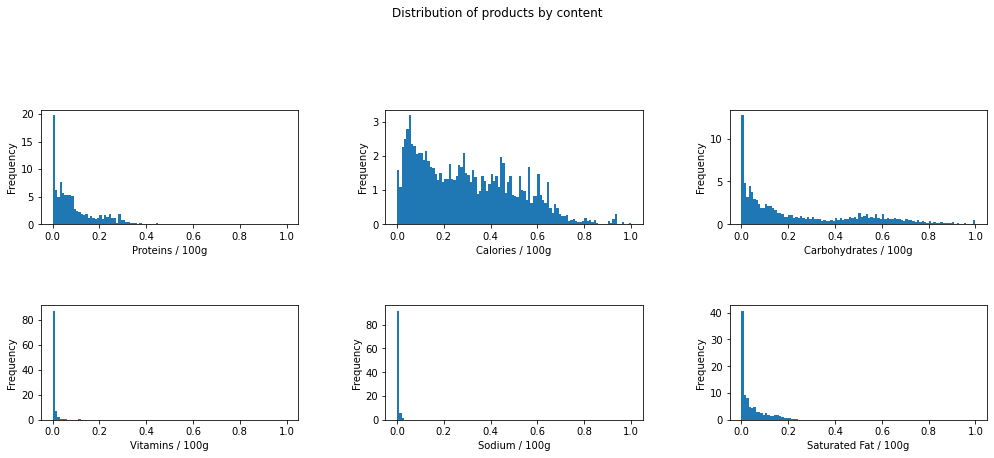

In [17]:
# Histogram of main Standardized Variables

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3)

fig.set_figheight(7)
fig.set_figwidth(15)

fig.suptitle('Distribution of products by content')

axs[0, 0].hist(Data3['proteins_100g'], bins=100, density=True)
axs[0, 0].set(xlabel='Proteins / 100g', ylabel='Frequency')
 
axs[0, 1].hist(Data3['energy_100g'], bins=100, density=True)
axs[0, 1].set(xlabel='Calories / 100g', ylabel='Frequency')

axs[0, 2].hist(Data3['carbohydrates_100g'], bins=100, density=True)
axs[0, 2].set(xlabel='Carbohydrates / 100g', ylabel='Frequency')

axs[1, 0].hist(Data3['Vitamins'][Data3['Vitamins'] > 0], bins=100, density=True)
axs[1, 0].set(xlabel='Vitamins / 100g', ylabel='Frequency')

axs[1, 1].hist(Data3['sodium_100g'][Data3['sodium_100g'] < 4], bins=100, density=True)
axs[1, 1].set(xlabel='Sodium / 100g', ylabel='Frequency')

axs[1, 2].hist(Data3['saturated-fat_100g'], bins=100, density=True)
axs[1, 2].set(xlabel='Saturated Fat / 100g', ylabel='Frequency')

    
fig.tight_layout(pad=5.0)

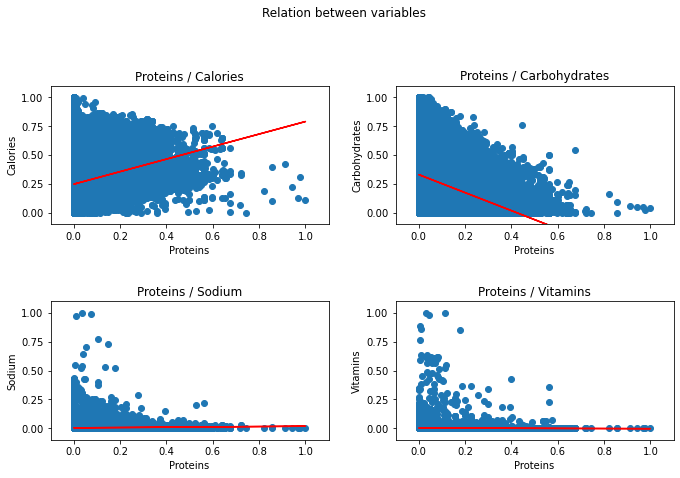

In [18]:
# Relation between variables

fig, axs = plt.subplots(2, 2)

fig.set_figheight(7)
fig.set_figwidth(10)

fig.suptitle('Relation between variables')

axs[0, 0].scatter(Data3['proteins_100g'], Data3['energy_100g'])
axs[0, 0].set_title('Proteins / Calories')

bingo = Data3['proteins_100g'].iloc[0:100000]
bongo = Data3['energy_100g'].iloc[0:100000]

m, b = np.polyfit(bingo, bongo, 1)

axs[0, 0].plot(Data3['proteins_100g'], Data3['proteins_100g']*m+b, color='red')
axs[0, 0].set_xlim([-0.1,1.1])
axs[0, 0].set_ylim([-0.1,1.1])
axs[0, 0].set(xlabel='Proteins', ylabel='Calories')

axs[0, 1].scatter(Data3['proteins_100g'], Data3['carbohydrates_100g'])
axs[0, 1].set_title('Proteins / Carbohydrates')

bingo = Data3['proteins_100g'].iloc[0:100000]
bongo = Data3['carbohydrates_100g'].iloc[0:100000]

m, b = np.polyfit(bingo, bongo, 1)

axs[0, 1].plot(Data3['proteins_100g'], Data3['proteins_100g']*m+b, color='red')
axs[0, 1].set_xlim([-0.1,1.1])
axs[0, 1].set_ylim([-0.1,1.1])
axs[0, 1].set(xlabel='Proteins', ylabel='Carbohydrates')

axs[1, 0].scatter(Data3['proteins_100g'], Data3['sodium_100g'])
axs[1, 0].set_title('Proteins / Sodium')

bingo = Data3['proteins_100g'].iloc[0:100000]
bongo = Data3['sodium_100g'].iloc[0:100000]

m, b = np.polyfit(bingo, bongo, 1)

axs[1, 0].plot(Data3['proteins_100g'], Data3['proteins_100g']*m+b, color='red')
axs[1, 0].set_xlim([-0.1,1.1])
axs[1, 0].set_ylim([-0.1,1.1])
axs[1, 0].set(xlabel='Proteins', ylabel='Sodium')


axs[1, 1].scatter(Data3['proteins_100g'], Data3['Vitamins'])
axs[1, 1].set_title('Proteins / Vitamins')

bingo = Data3['proteins_100g'].iloc[0:100000]
bongo = Data3['Vitamins'].iloc[0:100000]

m, b = np.polyfit(bingo, bongo, 1)

axs[1, 1].plot(Data3['proteins_100g'], Data3['proteins_100g']*m+b, color='red')
axs[1, 1].set_xlim([-0.1,1.1])
axs[1, 1].set_ylim([-0.1,1.1])
axs[1, 1].set(xlabel='Proteins', ylabel='Vitamins')


fig.tight_layout(pad=3.0)


### 4. Creation du "Protein_Score" puis comparaison avec nutriscore

Ici je crée un "Protein_Score" dont l'objectif est de classer les aliments par intensité en protéines compte-tenu de leurs matières grasses. L'indice est calculé en prenant le carré des proteines auquel on ajoute 0,1 fois les vitamines, le tout divisé par la quantité de calories fois la moitié de la quantité de sel, fois le quart de la quantité des 'carbohydrates', fois 0,1 fois la quanitié de "saturated fats".
J'effectue ensuite une transformation concave du "protein_score", sinon la distribution par 'protein_score' est extrèmement "skewed to the left".

Ensuite je construit quelques graphiques:
 - Un histogramme du 'protein_score'
 - Un "pie chart" de la distribution des aliments par catégorie nutriscore
 - Un "box plot" montrant la distribution des aliments par 'protein_score' conditionnel sur leur nutriscore (A, B, C, D, E).
 - 5 histogrammes des distributions conditionelles de 'proteins_scores' superposés selon leur nutriscore.

In [19]:
# Create a Protein_Score index

Data3['Protein_Score'] = ((Data3['proteins_100g']*10)**2 + 0.1*Data3['Vitamins']) / (Data3['energy_100g']*(1+0.5*Data3['salt_100g'])*(1+0.25*Data3['carbohydrates_100g'])*(1+0.1*Data3['saturated-fat_100g']))
Data3['Protein_Score'] = Data3['Protein_Score'].fillna(0)
Data3['Protein_Score'].replace(np.inf, 0, inplace=True)

Data3['Protein_Score'][Data3['Protein_Score'] > 100] = 100
Data3['Protein_Score'] = (Data3['Protein_Score'])**0.35

<ipython-input-19-5d2c16095216>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data3['Protein_Score'][Data3['Protein_Score'] > 100] = 100


Text(0, 0.5, 'Frequency')

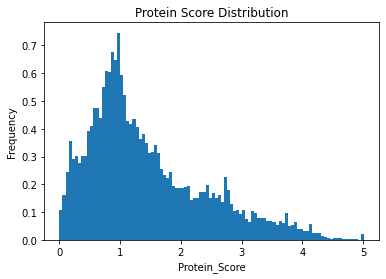

In [20]:
# Histogram of 'Protein_Score' variable

plt.hist(Data3['Protein_Score'][(Data3['Protein_Score'] > 0)], bins=100, density=True)
plt.title("Protein Score Distribution")
plt.xlabel('Protein_Score')
plt.ylabel('Frequency')

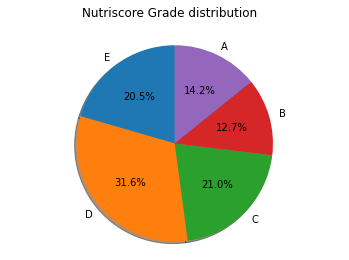

In [21]:
# Pie chart of Nutriscore

Share = []
labels = 'E', 'D', 'C', 'B', 'A'
explode = (0, 0, 0, 0, 0)

Share.append(Data3['nutriscore_grade'][Data3['nutriscore_grade'] == 'e'].count() / len(Data3['nutriscore_grade']))
Share.append(Data3['nutriscore_grade'][Data3['nutriscore_grade'] == 'd'].count() / len(Data3['nutriscore_grade']))
Share.append(Data3['nutriscore_grade'][Data3['nutriscore_grade'] == 'c'].count() / len(Data3['nutriscore_grade']))
Share.append(Data3['nutriscore_grade'][Data3['nutriscore_grade'] == 'b'].count() / len(Data3['nutriscore_grade']))
Share.append(Data3['nutriscore_grade'][Data3['nutriscore_grade'] == 'a'].count() / len(Data3['nutriscore_grade']))


fig1, ax1 = plt.subplots()
ax1.pie(Share, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig1.suptitle('Nutriscore Grade distribution')

plt.show()

Text(0.5, 1.0, 'Box Plot of Protein Score for each Nutriscore category')

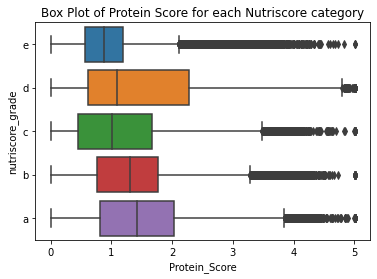

In [22]:
# Distribution of 'Protein Score' for each Nutriscore Grade category

import seaborn as sns

sns.boxplot(x='Protein_Score', y='nutriscore_grade', data=Data3, order=['e', 'd', 'c', 'b', 'a']).set_title('Box Plot of Protein Score for each Nutriscore category')


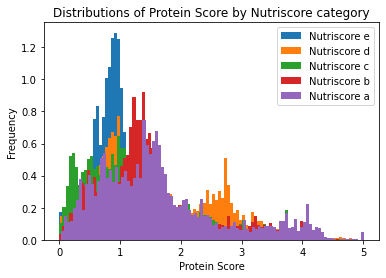

In [23]:
# Histograms of Protein_Score distributions for each Nutriscore category

plt.hist(Data3['Protein_Score'][(Data3['nutriscore_grade'] == 'e') & (Data3['Protein_Score'] > 0)], bins=100, density=True, label='Nutriscore e' )
plt.hist(Data3['Protein_Score'][(Data3['nutriscore_grade'] == 'd') & (Data3['Protein_Score'] > 0)], bins=100, density=True, label='Nutriscore d')
plt.hist(Data3['Protein_Score'][(Data3['nutriscore_grade'] == 'c') & (Data3['Protein_Score'] > 0)], bins=100, density=True, label='Nutriscore c')
plt.hist(Data3['Protein_Score'][(Data3['nutriscore_grade'] == 'b') & (Data3['Protein_Score'] > 0)], bins=100, density=True, label='Nutriscore b')
plt.hist(Data3['Protein_Score'][(Data3['nutriscore_grade'] == 'a') & (Data3['Protein_Score'] > 0)], bins=100, density=True, label='Nutriscore a')
plt.legend(loc='upper right')
plt.title('Distributions of Protein Score by Nutriscore category')
plt.xlabel('Protein Score')
plt.ylabel('Frequency')
plt.show()

### 5. Conclusion

Le "Protein_Score" semble-être positivement corrélé avec le nutriscore, mais la corrélation est assez faible puisque la variance des "Protein_Scores" au sein de chaque catégorie de nutriscore est grande. 

Par conséquent le "Protein_Score" fournit une information au consommateur qui est complémentaire avec le nutriscore.

En mangeant des produits avec haut nutriscore (A) et haut "Protein_Score" (4 ou plus), le consommateur peut suivre un régime équilibré et protéiné.

In [44]:
print(Data3[['product_name', 'brands', 'nutriscore_grade', 'Protein_Score']][(Data3['nutriscore_grade'] == 'a') & (Data3['Protein_Score'] > 4)])

                                 product_name                     brands  \
1156    Fresh Extra Lean Ground Turkey Breast                     Kroger   
3162        Premium chunk light tuna in water                        NaN   
3589                       Traditional Seitan  Sweet Earth Natural Foods   
3888                  Langostino meat 60-90ct                        NaN   
4088                             Naked shrimp                        NaN   
...                                       ...                        ...   
124721                         YellowFin Tuna                 Woolworths   
124789                                   Tuna                     Edgell   
124824                    tuna in springwater                      Coles   
124841  Sustainable Open Range Kangaroo Diced   Gourmet Game,Macro Meats   
124930            Tuna chunks in spring water                  Greenseas   

       nutriscore_grade  Protein_Score  
1156                  a       4.205035  
3162 